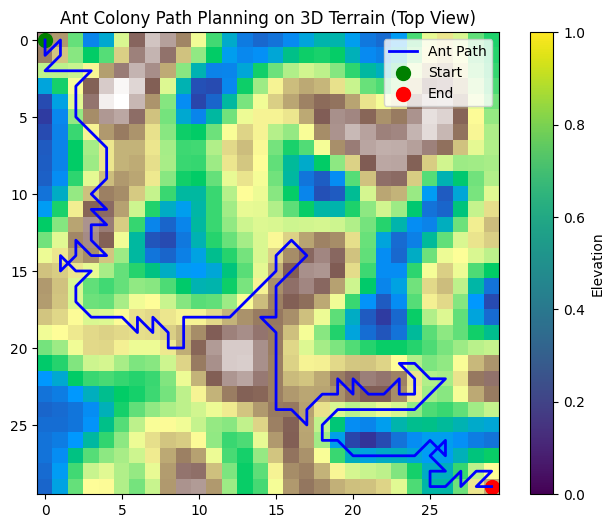

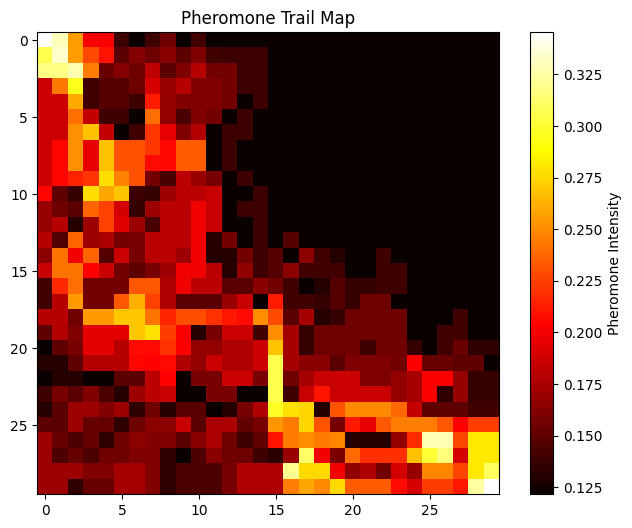

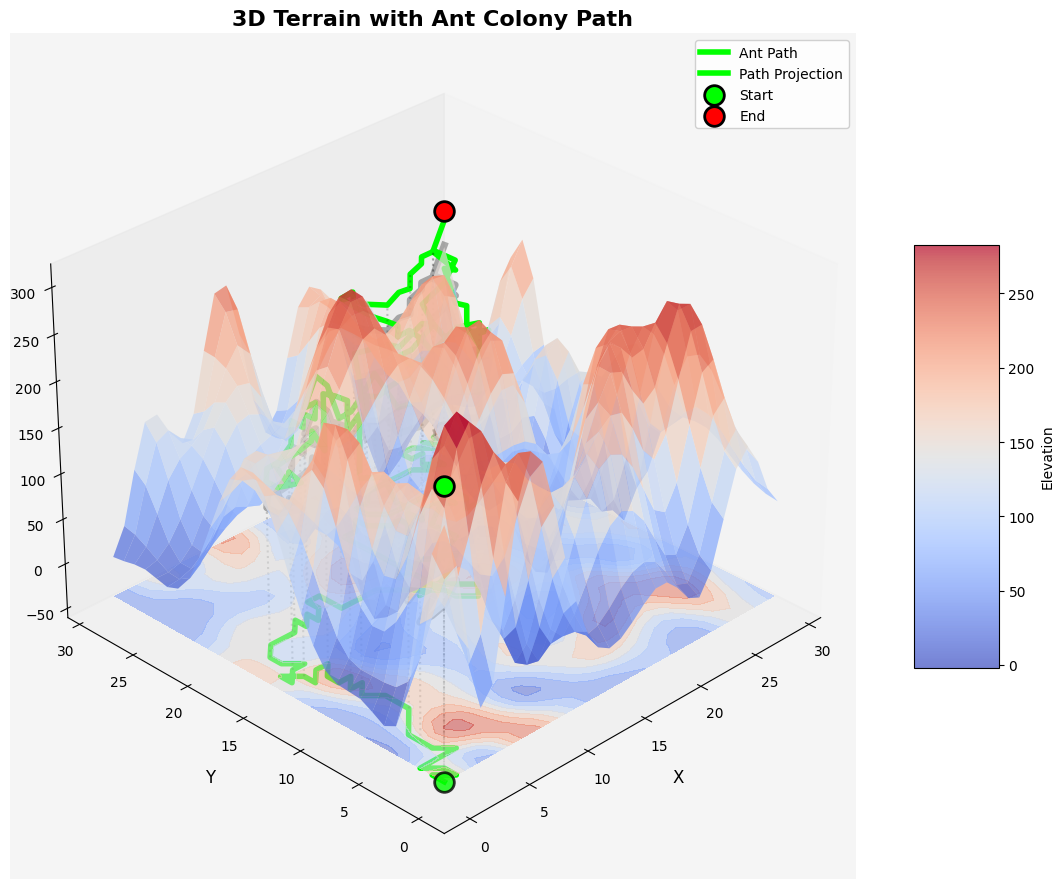

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import random

# ==== CONFIG ====
GRID_SIZE = (30, 30)
NUM_ANTS = 50
NUM_ITERATIONS = 20
EVAPORATION_RATE = 0.1
ALPHA = 1.0 # Importance of pheromones in path selection
BETA = 2.0 # Importance of heuristic (distance) in path selection
Q = 100  # Pheromone deposit constant

START = (0, 0)
END = (29, 29)

# ==== 1. TERRAIN ====

base_noise = np.random.rand(10, 10)
terrain = zoom(base_noise, (GRID_SIZE[0]/10, GRID_SIZE[1]/10))
terrain = (terrain * 255).astype(int)
pheromone_map = np.ones(GRID_SIZE)

# ==== 2. DISTANCE FUNCTION WITH ELEVATION ====
def distance_with_elevation(a, b, terrain): #grid cells
    dx = abs(a[0] - b[0])
    dy = abs(a[1] - b[1])
    dh = abs(terrain[a] - terrain[b])
    return np.sqrt(dx*dx + dy*dy + dh*dh)

# ==== 3. CHAOS FUNCTION ====
def chaos_map(x):
    return 4 * x * (1 - x)

# ==== 4. ANT WALK ====
def ant_walk_with_chaos(start, end, terrain, pheromone_map, chaos_seed):
    path = [start]
    visited = set()
    pos = start
    chaos = chaos_seed
    steps = 0
    max_steps = GRID_SIZE[0] * GRID_SIZE[1] * 2

    while pos != end and steps < max_steps:
        steps += 1
        visited.add(pos)

        directions = [(-1,0), (1,0), (0,-1), (0,1), (-1,-1), (-1,1), (1,-1), (1,1)]
        neighbors = [(pos[0]+dx, pos[1]+dy) for dx, dy in directions
                     if 0 <= pos[0]+dx < GRID_SIZE[0] and 0 <= pos[1]+dy < GRID_SIZE[1]
                     and (pos[0]+dx, pos[1]+dy) not in visited]

        if not neighbors:
            return None

        move_probs = []
        total = 0
        for n in neighbors:
            pheromone = pheromone_map[n]
            distance = distance_with_elevation(pos, n, terrain)
            heuristic = 1 / (distance + 1e-3)
            prob = (pheromone ** ALPHA) * (heuristic ** BETA)
            move_probs.append(prob)
            total += prob

        if total == 0:
            return None

        move_probs = [p / total for p in move_probs]
        chaos = chaos_map(chaos)
        choice_index = np.random.choice(len(neighbors), p=move_probs)
        pos = neighbors[choice_index]
        path.append(pos)

    return path if pos == end else None


# ==== 5. ACO MAIN ====
def multi_race_ant_colony(start, end, terrain, iterations=NUM_ITERATIONS):
    best_path = None
    best_cost = float('inf')

    for iter in range(iterations):
        all_paths = []
        chaos_values = [random.random() for _ in range(NUM_ANTS)]
        for c in chaos_values:
            path = ant_walk_with_chaos(start, end, terrain, pheromone_map, c)
            if path:
                all_paths.append(path)
                cost = sum(distance_with_elevation(path[i], path[i+1], terrain) for i in range(len(path)-1))
                if cost < best_cost:
                    best_path = path
                    best_cost = cost

        pheromone_map[:] *= (1 - EVAPORATION_RATE)
        for path in all_paths:
            cost = sum(distance_with_elevation(path[i], path[i+1], terrain) for i in range(len(path)-1))
            for cell in path:
                pheromone_map[cell] += Q / cost

    return best_path

# ==== 6. VISUALIZE PATH ====
def plot_path_on_terrain(terrain, path, start, end):
    plt.figure(figsize=(8, 6))
    plt.imshow(terrain, cmap='terrain')
    if path:
        x, y = zip(*path)
        plt.plot(y, x, color='blue', linewidth=2, label='Ant Path')
    plt.scatter(start[1], start[0], color='green', s=100, label='Start')
    plt.scatter(end[1], end[0], color='red', s=100, label='End')
    plt.colorbar(label='Elevation')
    plt.title("Ant Colony Path Planning on 3D Terrain (Top View)")
    plt.legend()
    plt.grid(False)
    plt.show()

# ==== 7. PHEROMONE HEATMAP ====
def plot_pheromone_map(pheromone_map):
    plt.figure(figsize=(8, 6))
    plt.imshow(pheromone_map, cmap='hot')
    plt.colorbar(label='Pheromone Intensity')
    plt.title("Pheromone Trail Map")
    plt.grid(False)
    plt.show()


# ==== 8. 3D TERRAIN PLOT ====
def plot_3d_terrain_with_path(terrain, path=None, start=None, end=None):
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    X = np.arange(terrain.shape[1])
    Y = np.arange(terrain.shape[0])
    X, Y = np.meshgrid(X, Y)
    Z = terrain

    z_min = np.min(Z) - 20

    surf = ax.plot_surface(X, Y, Z, cmap='coolwarm',
                          edgecolor='none',
                          linewidth=0,
                          antialiased=True,
                          alpha=0.7)

    cset = ax.contourf(X, Y, Z, zdir='z', offset=z_min, cmap='coolwarm', alpha=0.5)

    if path:
        path_x = [p[1] for p in path]
        path_y = [p[0] for p in path]

        path_elevation_offset = 30
        path_z = [terrain[y][x] + path_elevation_offset for x, y in zip(path_x, path_y)]

        ax.plot(path_x, path_y, [terrain[y][x] + 2 for x, y in zip(path_x, path_y)],
                color='black', linewidth=5, alpha=0.3)

        ax.plot(path_x, path_y, path_z, color='lime', linewidth=4, label='Ant Path')

        ax.plot(path_x, path_y, [z_min] * len(path_x),
                color='lime', linewidth=4, linestyle='-', alpha=1.0, label='Path Projection')

        for i, (x, y, z) in enumerate(zip(path_x, path_y, path_z)):
            if i % 3 == 0:
                ax.plot([x, x], [y, y], [z_min, z], color='black', alpha=0.2, linestyle=':')

    marker_size = 200
    elevation_boost = 40
    if start:
        ax.scatter(start[1], start[0], terrain[start] + elevation_boost,
                  color='lime', s=marker_size, label='Start',
                  edgecolor='black', linewidth=2)
        ax.scatter(start[1], start[0], z_min,
                  color='lime', s=marker_size,
                  edgecolor='black', linewidth=2, alpha=0.8)
    if end:
        ax.scatter(end[1], end[0], terrain[end] + elevation_boost,
                  color='red', s=marker_size, label='End',
                  edgecolor='black', linewidth=2)
        ax.scatter(end[1], end[0], z_min,
                  color='red', s=marker_size,
                  edgecolor='black', linewidth=2, alpha=0.8)

    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Elevation')

    ax.view_init(elev=30, azim=225)

    ax.grid(False)
    ax.set_facecolor('whitesmoke')

    ax.set_title("3D Terrain with Ant Colony Path", fontsize=16, fontweight='bold')
    ax.set_xlabel('X', fontsize=12, labelpad=10)
    ax.set_ylabel('Y', fontsize=12, labelpad=10)
    ax.set_zlabel('Elevation', fontsize=12, labelpad=10)


    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right', frameon=True, framealpha=0.9)

    plt.tight_layout()
    plt.show()


# ==== RUN EVERYTHING ====
best_path = multi_race_ant_colony(START, END, terrain)

if best_path:
    plot_path_on_terrain(terrain, best_path, START, END)
    plot_pheromone_map(pheromone_map)
    plot_3d_terrain_with_path(terrain, best_path, START, END)
else:
    print("No path found.")